# Looking into the SAT data of New York schools
This guided project project is built based on the DataQuest article of the series Building a Data Science Portfolio: [Storytelling with Data](https://www.dataquest.io/blog/data-science-portfolio-project/). 
The project consists in analyzing the [SAT scores](https://en.wikipedia.org/wiki/SAT) of high schoolers from different boroughs, along with other information related to it. As explained in the [article](https://www.dataquest.io/blog/data-science-portfolio-project/):
> The SAT, or Scholastic Aptitude Test, is a test that high schoolers take in the US before applying to college. Colleges take the test scores into account when making admissions decisions, so it's fairly important to do well on. The test is divided into 3 sections, each of which is scored out of 800 points. The total score is out of 2400 (although this has changed back and forth a few times, the scores in this dataset are out of 2400). High schools are often ranked by their average SAT scores, and high SAT scores are considered a sign of how good a school district is.

There has been allegation of the SAT tests being unfair with racial groups in the US, we're going to look at this too.  

## 1 Collecting our data
This is the moment in which we are going to download the files and look for extra information to complement it, so we can move to see how it looks like.
### 1.1 Downloading all data

To make such a big analysis, we need to take the right amount of data. Thinking about that, we are going to take data from the following sources:
* [High School Directory](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2) - directory containing information about each high school
* [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) — SAT scores for each high school in New York City.
* [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) — attendance information on every school in NYC.
* [Math test results](https://data.cityofnewyork.us/Education/NYS-Math-Test-Results-By-Grade-2006-2011-School-Le/jufi-gzgp) — math test results for every school in NYC.
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) — class size information for each school in NYC.
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) — Advanced Placement exam results for each high school. Passing AP exams can get you college credit in the US.
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) — percentage of students who graduated, and other outcome information.
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) — demographic information for each school.
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) — surveys of parents, teachers, and students at each school.
* [School district maps](https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj) — contains information on the layout of the school districts, so that we can map them out.

### 1.2 Getting background information

- New York city is divided into 5 boroughs, which are essentially distinct regions;
- Schools in New York city are divided into several school districts, each of which can contain dozens of schools;
- Not all the schools in all of the dataset are high schools;
- Each school in New York city has a unique code called a `DNB` or District Borough Number;
- By aggregating the data by district, we can use the district mapping data to plot district-by-district differences;

## 2 Understanding our data
After all the collection we need to see how it works, but first of all lets import the libraries we are going to use.
### 2.1 Setting up the environment
Lets import all libraries we are goingo to need to clean, analyze and display the data.

In [1]:
# importing numpy and pandas to the analysis
import numpy as np
import pandas as pd

# importing the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Libraries imported!")

Libraries imported!


### 2.2 Opening and reading the csv files
Now we are going to open our data and read it into pandas dataframes so we can understand how it looks like.

In [2]:
# creating a list with the name of our csv files
csv_files = ['ap_2010.csv', 
             'class_size.csv', 
             'demographics.csv', 
             'graduation.csv', 
             'hs_directory.csv', 
             'math_test_results.csv', 
             'sat_results.csv', 
             'school_attendence.csv']

# populating the dataframes with the csv files from my GitHub repository
data = {}
for f in csv_files:
    d = pd.read_csv('https://raw.githubusercontent.com/nathpignaton/guided_projects/main/nyc-sat_analysis/{}'.format(f))
    # creating the key without the .csv in the name and storing the data
    data[f.replace('.csv', '')] = d
    
# checking to see if it worked
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'math_test_results', 'sat_results', 'school_attendence'])

After reading our data and storing it in a dictionary, the next step is to see if is looks the way we want.

In [3]:
# reading the first five rows of each dataframe
for k in data.keys():
    print('\n {} \n {}'.format(k, data[k].head()))


 ap_2010 
       DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  

 class_size 
    CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 R

Looking at our data we can see some things:
- Most of the datasets contain the `DBN` column;
- Some fields look interesting for mapping;
- Some of the datasets appear to contain multiple rows for each school, showing that we'll have to do some preprocessing.  

Before coming back to our dataframes, let's read the information in the survey txt files.

### 2.3 Opening and reading the txt files
Now we are going to open our survey data and read it into pandas dataframes almost the same way we did before.  
We are going to store each survey in a different dataframe, they will be called `all_survey` and `d75_survey`, after it we'll concatenate the two into only one `survey` dataframe. This files need a specific encoding to be read: `windows-1252` and next we are going to read it and extract the information we are going to need.

In [4]:
# reading the files into dataframes
all_survey = pd.read_csv("https://raw.githubusercontent.com/nathpignaton/guided_projects/main/nyc-sat_analysis/survey_all.txt", 
                         delimiter="\t", encoding="windows-1252")

d75_survey = pd.read_csv("https://raw.githubusercontent.com/nathpignaton/guided_projects/main/nyc-sat_analysis/survey_d75.txt", 
                         delimiter="\t", encoding="windows-1252")

# concatenating both
survey = pd.concat([all_survey, d75_survey], axis=0)

# checking it out
print(survey.shape)
survey.head()

(1702, 2773)


,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see above, the resulting dataframe has more than 2000 columns, so we see that we need to reduce it, since we do not need all of them and its easier to work with less columns.  
Thanks to the [dictionary of the survey data](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) we can keep the columns we know we'll need and remove the other ones.

In [5]:
# copying the data from `DBN` column to `dbn` column to fit the name pattern
survey['DBN'] = survey['dbn']

# selecting the columns we want
columns_filter = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", 
                  "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", 
                  "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

# removing the other columns
survey = survey.loc[:, columns_filter]

# adding it to the dictionary
data['survey'] = survey

data['survey'].shape

(1702, 23)

## 3 Data Preprocessing

First thing will be unify our data based on a common column, in our casa this common column is `DBN`. DBN is the District Borough Number and it is the combination of the District Number, the letter code for the borough, and the number of the school. 

### 3.1 Treating the `DBN` columns

We are going to need to change the names of the columns in every dataset that is not the `hs_directory` dataframe so it is all lowercase, and create the `dbn` column in the `class_size` dataset too.  
Let's rename the `dbn` column to `DBN` in the `hs_directory` dataset.  

To help us understand what happened in the change, the loop has some specific phrases that tell us what happened to the entry: name successfully changed, name already in lowercase or no DBN column.  
We are also going to use a cool class that makes easy print text with different colors in python, so the information can be clear. Bellow we are going to create it, the topic about different font printing in Python in StackOverflow can be found [here](https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747). 

In [6]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [7]:
# changin the name of the DBN columns to lower case (all of them)
for item in data.keys():
    if ('DBN') in data[item].columns: 
        data[item].rename({'DBN':'dbn'}, axis=1, inplace=True)
        print("The {} DBN column was changed to lowercase.".format(item))
    elif ('dbn') in data[item].columns:
        print("The {} DBN column is already lowercase.".format(item))
    else:
        # let's make this information a litte bit more visible
        print(color.BLUE + color.BOLD + "The {} has no DBN.".format(item) + color.END)

The ap_2010 DBN column was changed to lowercase.
The class_size has no DBN.
The demographics DBN column was changed to lowercase.
The graduation DBN column was changed to lowercase.
The hs_directory DBN column is already lowercase.
The math_test_results DBN column was changed to lowercase.
The sat_results DBN column was changed to lowercase.
The school_attendence has no DBN.
The survey DBN column was changed to lowercase.


As we can see above, the `class_size` and `school_attendence` have no `DBN` or `dbn` column, let's look at these specific dataframes to see if the information is there, in any other form. But first, let's look at the `dbn` values to see how they look like.

In [8]:
# a sample of what the dbn looks like
data['demographics']['dbn'].unique()

array(['01M015', '01M019', '01M020', ..., '32K554', '32K556', '32K564'],
      dtype=object)

As we can see above, the `dbn` values are made of two numbers, followed by a letter and other three numbers. With that in mind we can see that the information we need is already in `class_size` and `school attendence` is not separated by schools, but by District, so we are going to leave it as it is for now.  

Next let's take a look in the `class_size` columns.

In [9]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


As we can see above, the `DBN` is just the union of the `CSD` and `SCHOOL CODE` columns. But to do so we need two insert an extra 0 to the number when needed, since the `DBN` is composed by two numbers in the beggining, not one. After it we can concatenate the other values.

In [10]:
# creating a function to do it to the whole column
def insert_zero(number):
    # the number need to be a string to be concatenated
    string = str(number)
    size = len(string)
    # if it is a one digit number, it will turn it into a two digit number
    if size == 1:
        return string.zfill(2)
    # if it is a two digit number, nothing happens
    if size == 2:
        return string
    
# applying to the column
data['class_size']['two_digit_csd'] = data['class_size']['CSD'].apply(insert_zero)

# concateneting the columns
data['class_size']['dbn'] = data['class_size']['two_digit_csd'] + data['class_size']['SCHOOL CODE']

data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,two_digit_csd,dbn
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


Now we still need to convert the columns `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` columns in the `sat_score`, containing only one per DBN.
### 3.2 Creating the main `sat_score` column in the `sat_results` dataframe 
To make the calculation we need to convert the columns to numbers first.

In [11]:
# converting the columns
data['sat_results']['SAT Math Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Math Avg. Score'], 
                                                           errors='coerce')

data['sat_results']['SAT Critical Reading Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Critical Reading Avg. Score'], 
                                                                       errors='coerce')

data['sat_results']['SAT Writing Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Writing Avg. Score'],
                                                              errors='coerce')

# calculating the sat_score column
data['sat_results']['sat_score'] = data['sat_results']['SAT Math Avg. Score'] + data['sat_results']['SAT Critical Reading Avg. Score'] + data['sat_results']['SAT Writing Avg. Score']

data['sat_results']['sat_score'].head()

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

Done that, we're going to extract the latitude and longitude values for each school in the `hs_directory`, so we can map the schools and uncover any geographic patterns.
### 3.3 Extracting the Latitude and Longitude from `hs_directory`
This will be done using a function that uses a regular expression to take the exact numbers we need.

In [12]:
import re

# latitude extractor
def extractor_lat(string):
    coords = re.findall("\(.+\)", string)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# longitude extractor
def extractor_long(string):
    coords = re.findall("\(.+\)", string)
    long = coords[0].split(",")[1].replace(")", "")
    return long

# using the functions to extract the latitude and longitude
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(extractor_lat)
data['hs_directory']['long'] = data['hs_directory']['Location 1'].apply(extractor_long)

print("lat\n", data['hs_directory']['lat'].head(), "\n\n", "long\n", data['hs_directory']['long'].head())

lat
 0    40.601989336
1    40.593593811
2    40.692133704
3    40.822303765
4    40.773670507
Name: lat, dtype: object 

 long
 0     -73.762834323
1     -73.984729232
2     -73.931503172
3      -73.85596139
4     -73.985268558
Name: long, dtype: object


Once we've done that, we still have to do a few things before combining the data. If we look close enough, we can see that the DBN values are not unique. Since we are looking for the SAT data, we need only the data correspondent to the later grades. We are also going to look the program types, each school have multiple program types, because of that, we are going to choose the largest category. We also need to check the class size, that has multiple entries due to the different subjects.

### 3.4 Working the `class_size` dataframe to contain unique DBNs

To do so, we are going to filter the `class_size` data so the `GRADE` column has only `09-12` grades. Next lets take a look into the `PROGRAM TYPE` column, only after it we can move on to the `CORE SUBJECT` column.

In [13]:
class_size = data['class_size']

# filtering GRADE values
class_size = class_size[class_size['GRADE '] == '09-12']

# checking the PROGAM TYPE values
class_size['PROGRAM TYPE'].value_counts()

GEN ED     6513
CTT        2953
SPEC ED    1178
Name: PROGRAM TYPE, dtype: int64

As we saw above, `GEN ED` is the category with the most amount of entries, with that in mind, we are going to use it.

In [14]:
# filtering the PROGRAM TYPE
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

# checking the new df
class_size.describe(include='all')

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,two_digit_csd,dbn
count,6513.000000,6513,6513,6513,6513,6513,6513,6513,6513,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513,0.0,6513,6513
unique,NaN,5,583,583,1,1,4,22,1,NaN,NaN,NaN,NaN,NaN,1,NaN,32,583
top,NaN,K,K505,"Bronx School for Law, Government and Justice",09-12,GEN ED,ENGLISH,Integrated Algebra,-,NaN,NaN,NaN,NaN,NaN,STARS,NaN,02,20K505
freq,NaN,1927,21,21,6513,6513,1977,449,6513,NaN,NaN,NaN,NaN,NaN,6513,NaN,814,21
mean,14.266697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.045755,6.682788,24.748549,19.675725,28.739751,NaN,NaN,NaN,NaN
std,9.275239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253.464004,8.506092,5.499972,6.473547,6.315539,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,1.000000,6.000000,5.000000,6.000000,NaN,NaN,NaN,NaN
25%,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.000000,2.000000,21.200000,14.000000,25.000000,NaN,NaN,NaN,NaN
50%,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.000000,4.000000,25.000000,19.000000,30.000000,NaN,NaN,NaN,NaN
75%,22.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184.000000,7.000000,28.800000,24.000000,34.000000,NaN,NaN,NaN,NaN


Now that we've filtered the information, we still need to group the information to show it per DBN. Looking closely into the columns, we can see that the class sizes are separated into major subjects and other specific subjects related. This isn't relevant for us, since our objective is to analyze data per school.

In [15]:
# looking into the CORE SUBJECT column
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,two_digit_csd,dbn
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


With that in mind, we are going to group the dataset calculating the averages per DBN.

In [16]:
# grouping the dataset into a new variable
grouped = class_size.groupby('dbn')

# calculating the mean 
class_size = grouped.agg(np.mean)

# reseting index and turning dbn a column again
class_size = class_size.reset_index() 

# assigning it back to the dictionary
data['class_size'] = class_size

data['class_size'].head()

,dbn,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


Next we are going to treat the `demographics` dataframe to contain only unique DBNs.
### 3.5 Working the `demographics`  dataframe to contain unique DBNs 
In this dataframe, the main problem is related to the school year. The dataset has information from various years. In our analysis we are going to use only the most recent data, so we are going to filter the `20112012` data.

In [17]:
demographics = data['demographics']

# filtering the entries
demographics = demographics[demographics['schoolyear'] == 20112012]

# assigning it back to the dictionary
data['demographics'] = demographics

data['demographics'].head()

,dbn,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


Done that we will move to the last dataframe to condense `gradutation`.
### 3.6 Working the `graduation`  dataframe to contain unique DBNs
In the graduation dataframe, the `Demographic` and `Cohort` are the ones preventing the DBN to be unique. `Cohort` appears to refer to the year the data represents, and the `Demographic` appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is **2006**. We also want data from the full cohort, so we'll only pick rows where Demographic is **Total Cohort**.  
Let's filter the dataset.

In [18]:
graduation = data['graduation']

# filtering both columns
graduation = graduation[graduation['Cohort'] == '2006']
graduation = graduation[graduation['Demographic'] == 'Total Cohort']

# assigning it back to the dictionary
data['graduation'] = graduation

data['graduation'].head()

,Demographic,dbn,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7,42,33.9,79.2,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8,67,74.4,95.7,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56.0,40,47.6,85.1,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4,91,47.2,86.7,...,22,11.4,21.0,14,7.3,13.3,53,27.5,35,18.1


After treating the unique DBNs, we still need to treat the `ap_2010` dataframe, because it has numeric values stored as strings.
### 3.6 Converting string numeric values to the right datatype
There are three columns we need this change to happen: `AP Test Takers `, `Total Exams Taken` and `Number of Exams with scores 3 4 or 5`. With a loop we are going to do the needed conversion.

In [19]:
# creating a list with the columns we need to convert
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

# loop to conversion
for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')
    
data['ap_2010'].dtypes

dbn                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

Now we are finally ready do merge our datasets.
## 4 Combining the Data
To do so, we are going to merge the data in a strategic way to always keep the most amount of DBNs possible, not removing any entry.
### 4.1 Merging the datasets one by one
With the objective of not losing any important value, we are going to merge the datasets using two different approaches, left and inner join.

In [20]:
combined = data['sat_results']

# combining dataset per dataset, based on the DBNs in the sat_results
combined = combined.merge(data['ap_2010'], how='left', on='dbn')
combined = combined.merge(data['graduation'], how='left', on='dbn')

print(combined.shape)
combined.head()

(479, 33)


,dbn,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0


In [21]:
# combining the datasets keeping only the entries in both dataframes
combined = combined.merge(data['class_size'], how='inner', on='dbn')
combined = combined.merge(data['demographics'], how='inner', on='dbn')
combined = combined.merge(data['survey'], how='inner', on='dbn')
combined = combined.merge(data['hs_directory'], how='inner', on='dbn')

print(combined.shape)
combined.head()

(363, 164)


,dbn,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,long
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713763947,-73.98526004
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712331851001,-73.984796625
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729782687,-73.983041441
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569079,-73.985672691
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725451,-73.979426386


Now that we've combined the data we can see that a lot of entries are missing, this is the result of the left joins we did, it happened because some DBNs did not have that information. To follow our analysis, we are going to fill this values with the mean of the correspondent column.
### 4.2 Dealing with missing values
We are going to use some methods to calculate the means and to fill the blank values with them.

In [22]:
# calculating the means
means = combined.mean()

# filling the missing values
combined = combined.fillna(means)
combined = combined.fillna(0)

# printing the null values per column
for column in combined.columns:
    print("{}: {}".format(column, combined[column].isnull().sum()))

dbn: 0
SCHOOL NAME: 0
Num of SAT Test Takers: 0
SAT Critical Reading Avg. Score: 0
SAT Math Avg. Score: 0
SAT Writing Avg. Score: 0
sat_score: 0
SchoolName: 0
AP Test Takers : 0
Total Exams Taken: 0
Number of Exams with scores 3 4 or 5: 0
Demographic: 0
School Name: 0
Cohort: 0
Total Cohort: 0
Total Grads - n: 0
Total Grads - % of cohort: 0
Total Regents - n: 0
Total Regents - % of cohort: 0
Total Regents - % of grads: 0
Advanced Regents - n: 0
Advanced Regents - % of cohort: 0
Advanced Regents - % of grads: 0
Regents w/o Advanced - n: 0
Regents w/o Advanced - % of cohort: 0
Regents w/o Advanced - % of grads: 0
Local - n: 0
Local - % of cohort: 0
Local - % of grads: 0
Still Enrolled - n: 0
Still Enrolled - % of cohort: 0
Dropped Out - n: 0
Dropped Out - % of cohort: 0
CSD: 0
NUMBER OF STUDENTS / SEATS FILLED: 0
NUMBER OF SECTIONS: 0
AVERAGE CLASS SIZE: 0
SIZE OF SMALLEST CLASS: 0
SIZE OF LARGEST CLASS: 0
SCHOOLWIDE PUPIL-TEACHER RATIO: 0
Name: 0
schoolyear: 0
fl_percent: 0
frl_percent:

Finished with the null values, we'll create a new column in our dataset to make an interesting analysis of the information we have, looking at in from a different angle.
### 4.3 Creating a column to store the district
Before analyzing our data, we are going to create a new column in the combined dataset with the two first characters of the schools DBN, correspondent to the district. This will be done with the objective of analyzing the information in a district level.

In [23]:
# creating a function that extracts the first two chars
def two_chars(string):
    return string[0:2]

# applying it to the whole column of dbn, storing in a new column
combined['school_dist'] = combined['dbn'].apply(two_chars)

combined['school_dist'].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

Once we've done that, we can start to look for insights in the dataset we've built. First thin we are going to do is look for correlations. 
## 5 Looking for correlations
Searching for correlations in a table manner would be very inconvenient for our data, since it has too many columns. With that in mind, we are going to plot heatmaps per group containing the correlations.  
We will start treating the dataframe to plot the heatmaps, after it we will create variables containing the columns of each group. We will start the analysis with the surveys of the parents, students and teachers.

In [24]:
corr = pd.DataFrame(combined.corr()['sat_score'])
corr

,sat_score
SAT Critical Reading Avg. Score,0.986820
SAT Math Avg. Score,0.972643
SAT Writing Avg. Score,0.987771
sat_score,1.000000
AP Test Takers,0.523140
...,...
Community Board,-0.060919
Council District,-0.076151
Census Tract,0.048737
BIN,0.052232


After treating the data to be plotted, we can start the analysis. 
### 5.1 Survey Correlations
The columns related to surveys were easy, since we've selected them before when we were merging them to the main dataframe. After plotting the map, we will be able to see which ones are correlated to the `sat_results`, with the name of the column, we can consult the dictionary of the data to understand the mean of that number.

In [25]:
# group of columns related to parents, students and teachers surveys
surveys = ['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 
           'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 
           'com_tot_11', 'eng_tot_11', 'aca_tot_11']

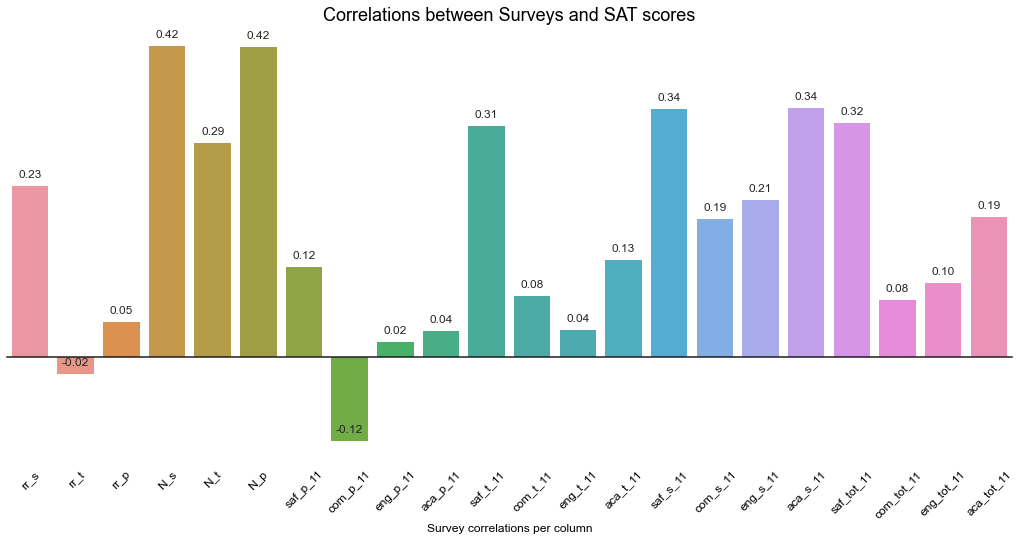

In [26]:
# configurating the size of the plot
fig, ax = plt.subplots(figsize=(18, 8))

# plotting a line graph
barplot = sns.barplot(x=surveys, y='sat_score', data=corr.loc[surveys], ax=ax)

# configurating the plot
plt.setp(fig.axes, yticks=[])
plt.xticks(rotation=45, size=12)
plt.xlabel("")
plt.yticks(size=12)
plt.tick_params(bottom=False)

ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("", size=12)
ax.set_xlabel("Survey correlations per column", size=12)
ax.set_title("Correlations between Surveys and SAT scores", size=18)

sns.despine(bottom=True, left=True, right=True)
sns.set(style="white")

# annotating the values in the bars
for bar in barplot.patches:
    barplot.annotate(format(bar.get_height(), '.2f'),
                    (bar.get_x() + bar.get_width()/2., bar.get_height()), 
                    ha='center', va='center', size=12, xytext=(0,12),
                    textcoords='offset points')


plt.show()

As we can see above, the columns `N_s` and `N_p` have the highest values: 0.42, the highest correlation coefficients in the group. These two columns are followed by `saf_s_11` and `aca_s_11`, with 0.34 each, finally comes `saf_tot_11` with 0.32 and `saf_t_11` with 0.31.  
Checking the dictionary, we can see the information bellow:  

| Column | Correlation | Information |  
| :--: | :--: | :--: |  
| N_s | 0.42 | Number of students respondents. |  
| N_p | 0.42 | Number of parents respondents. |
| saf_s_11 | 0.34 | Safety and respect score based on student responses.|
| aca_s_11 | 0.34 | Academic expectations 
| saf_tot_11 | 0.32 |
| saf_t_11 | 0.31 |